In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/OCEAN180"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
train = pd.read_csv(os.path.join(INPUT_DIR,"train_data.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test_data.csv"))
sample_sub = pd.read_csv(os.path.join(INPUT_DIR,"submit_example.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(sample_sub.shape)
display(sample_sub.head(3))

(14140, 3465)


,Unnamed: 0,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.989139,125.243167,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,1,26.996172,127.912024,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13
2,2,26.363556,127.735139,20.0,20091014,2009.0,10.0,0.025,NaN,0.0,...,0.579204,0.281260,-0.191884,-0.853730,-3.160207,3.324236,62.711236,3.284478,-57.136191,3927_22


(4039, 3464)


,Unnamed: 0,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.409346,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.540733,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.601792,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23


(4039, 2)


,0,1
0,0,0.47
1,1,0.68
2,2,0.25


In [ ]:
train.rename(columns={"Unnamed: 0":"id"}, inplace=True)
test.rename(columns={"Unnamed: 0":"id"}, inplace=True)

In [ ]:
def missing_func(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  df_missing = pd.concat([total,percent],axis=1,keys=['total','percent'])
  return df_missing 

In [ ]:
train_missing = missing_func(train)
test_missing = missing_func(test)

In [ ]:
train_cols = train.columns.tolist()
test_cols = test.columns.tolist()

target = "cover"
print(target)

display(train[target].head(3))

cover


0    0.050
1    0.725
2    0.025
Name: cover, dtype: float64

In [ ]:
train_missing_40 = train_missing[train_missing.percent<0.4].index
test_missing_40 =  test_missing[test_missing.percent<0.4].index
train_missing_15 = train_missing[train_missing.percent<0.15].index
test_missing_15 =  test_missing[test_missing.percent<0.15].index

categorical_features = train.dtypes[train.dtypes=="object"].index

features_40 = set(train_missing_40) & set(test_missing_40)
features_15 = set(train_missing_15) & set(test_missing_15)
features = set(features_40) - set(categorical_features)
knn_features = set(features) - set(features_15)  

In [ ]:
len(features), len(knn_features)

(2259, 512)

In [ ]:
land_sat_feats = []
for years in list(range(2000,2021)):
  n_f = [col for col in features if str(years) in col]
  land_sat_feats += n_f
features = [col for col in features if col not in land_sat_feats]
knn_features = [col for col in knn_features if col not in land_sat_feats]

In [ ]:
len(features), len(knn_features)

(309, 62)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tqdm

missing_train = train.fillna(9999)
missing_test = test.fillna(9999)

for mcol in tqdm(knn_features):
    knn_mtrain = missing_train.loc[missing_train[mcol]==9999]
    knn_train = missing_train.loc[missing_train[mcol]!=9999]
    knn_mtest = missing_test.loc[missing_test[mcol]==9999]

    knn = KNeighborsRegressor(n_neighbors=3)
    knn.fit(knn_train[features],knn_train[mcol])
    knn_mtrain[f"knn_{mcol}"] = knn.predict(knn_mtrain[features])
    knn_mtest[f"knn_{mcol}"] = knn.predict(knn_mtest[features])

    train = train.merge(knn_mtrain[["id",f"knn_{mcol}"]],how="left",on="id")
    train[mcol] = train[mcol].fillna(0)
    train[f"knn_{mcol}"] = train[f"knn_{mcol}"].fillna(0)
    train[mcol] = train[mcol] + train[f"knn_{mcol}"]

    test = test.merge(knn_mtest[["id",f"knn_{mcol}"]],how="left",on="id")
    test[mcol] = test[mcol].fillna(0)
    test[f"knn_{mcol}"] = test[f"knn_{mcol}"].fillna(0)
    test[mcol] = test[mcol] + test[f"knn_{mcol}"]

display(train[knn_features].head(10))
display(test[knn_features].head(10))

  0%|          | 0/62 [00:00<?, ?it/s]<ipython-input-13-b25a66a67f2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knn_mtrain[f"knn_{mcol}"] = knn.predict(knn_mtrain[features])
<ipython-input-13-b25a66a67f2a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knn_mtest[f"knn_{mcol}"] = knn.predict(knn_mtest[features])
  2%|▏         | 1/62 [00:02<02:24,  2.37s/it]<ipython-input-13-b25a66a67f2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

,NBR,Red,Chlgreen,Alteration,EVI,Landsat_num,TIRS2,DSWI,SAVI,Ferrous_Silicates,...,NDMI,Ferric_Oxides,SLAVI,AVI,SIPI2,Green,SWIR2,Chlred_edge,BWDRVI,Date_Acquired
0,0.945309,12.291277,5.441301,2.172491,0.076538,7.0,8.218559,2.304861,-0.676338,0.460301,...,0.884876,0.061078,55.834898,-15.589754,5.133805,24.466267,0.126413,2.733582,-0.980000,2.012012e+07
1,0.971470,50.989620,1.035625,6.263373,-0.243384,7.0,8.658948,2.496108,0.238271,0.159658,...,0.833784,0.090641,3658.334622,38.705406,-0.334153,72.848259,1.017969,0.724878,-0.832205,2.009071e+07
2,0.971226,18.480610,4.433729,5.613106,0.101124,7.0,8.255633,2.222647,-0.596540,0.178154,...,0.848540,0.081935,145.440316,-21.318088,4.059874,34.678707,0.114172,2.362776,-0.969846,2.009123e+07
3,0.972719,33.735753,2.197610,6.416499,0.103533,7.0,8.838449,1.984526,-0.263694,0.161917,...,0.838246,0.088156,868.810277,-17.434855,5.472865,46.825167,0.341719,1.554244,-0.918048,1.999759e+07
4,0.984011,9.919600,6.795114,5.911293,0.036670,7.0,8.375682,3.442151,-0.548395,0.169168,...,0.909053,0.047640,44.545636,-10.890392,9.859806,30.404083,0.036060,2.216966,-0.984732,2.008121e+07
5,0.972719,33.735753,2.197610,6.416499,0.103533,7.0,8.838449,1.984526,-0.263694,0.161917,...,0.838246,0.088156,868.810277,-17.434855,5.472865,46.825167,0.341719,1.554244,-0.918048,1.999759e+07
6,0.973090,15.022129,4.713927,5.881573,0.077201,7.0,8.259885,2.359482,-0.588467,0.170023,...,0.851482,0.080216,96.938546,-17.212898,5.083526,30.243046,0.087500,2.341471,-0.974746,2.009123e+07
7,0.944751,19.299984,10.618635,4.477353,0.079488,8.0,7.987241,3.033152,-0.844921,0.223346,...,0.774309,0.127199,101.353342,-28.176980,4.978285,55.338951,0.148056,3.703350,-0.986262,2.019091e+07
8,0.951746,17.650833,4.803614,4.271438,0.067698,7.0,9.141788,2.513713,-0.552662,0.234113,...,0.808965,0.105604,142.997158,-19.278593,5.682249,38.484325,0.198072,2.203177,-0.974801,2.009091e+07
9,0.965199,11.636496,5.361523,5.316467,0.061686,7.0,8.492517,2.575040,-0.593507,0.188095,...,0.827909,0.094146,57.407128,-13.479237,6.175073,26.254721,0.086716,2.376309,-0.979164,2.010112e+07


,NBR,Red,Chlgreen,Alteration,EVI,Landsat_num,TIRS2,DSWI,SAVI,Ferrous_Silicates,...,NDMI,Ferric_Oxides,SLAVI,AVI,SIPI2,Green,SWIR2,Chlred_edge,BWDRVI,Date_Acquired
0,0.972719,33.735753,2.197610,6.416499,0.103533,7.0,8.838449,1.984526,-0.263694,0.161917,...,0.838246,0.088156,868.810277,-17.434855,5.472865,46.825167,0.341719,1.554244,-0.918048,1.999759e+07
1,0.954783,15.177749,4.045716,4.433743,0.050914,7.0,8.814009,2.717712,-0.398572,0.231634,...,0.818370,0.100038,136.242456,-13.141754,7.369578,35.449848,0.203959,1.749661,-0.969327,2.009092e+07
2,0.971844,33.772681,1.945585,6.189369,0.091191,7.0,8.837255,2.010201,-0.215043,0.173532,...,0.840804,0.086700,905.070874,-15.260981,5.576378,46.699800,0.365417,1.390758,-0.914342,1.999759e+07
3,0.983847,11.296329,6.891628,8.397437,0.052273,7.0,8.568386,2.837816,-0.670245,0.119084,...,0.872004,0.068374,47.185164,-14.263588,7.156558,28.700424,0.033908,2.712507,-0.985025,2.010093e+07
4,0.966725,24.134905,7.386919,4.973023,0.167693,8.0,7.937538,1.942106,-0.911583,0.201085,...,0.844782,0.084139,138.114280,-36.870170,2.774381,42.104111,0.096436,4.234328,-0.980145,2.019111e+07
5,0.972410,32.193857,2.213430,6.207093,0.086634,7.0,8.838213,2.024242,-0.252810,0.172488,...,0.842444,0.085772,836.785779,-15.247592,5.637460,45.417629,0.337050,1.514408,-0.919191,1.999759e+07
6,0.970220,12.489099,5.185413,3.554037,0.054797,7.0,8.549272,2.726644,-0.551599,0.281370,...,0.898038,0.053720,70.906138,-13.700280,6.847657,29.240328,0.085234,2.214788,-0.978765,2.010112e+07
7,0.941589,14.640511,7.459252,4.194235,0.067871,8.0,8.479495,2.767933,-0.718348,0.238423,...,0.775917,0.126179,73.906687,-19.287441,5.690587,37.272316,0.150323,2.929983,-0.983447,2.019091e+07
8,0.982552,12.494470,4.872731,9.666928,0.061939,7.0,8.483115,2.612103,-0.536900,0.103445,...,0.843186,0.085077,72.460664,-13.437099,6.144190,28.144505,0.050833,2.163200,-0.975749,2.010112e+07
9,0.972719,33.735753,2.197610,6.416499,0.103533,7.0,8.838449,1.984526,-0.263694,0.161917,...,0.838246,0.088156,868.810277,-17.434855,5.472865,46.825167,0.341719,1.554244,-0.918048,1.999759e+07


## Model

In [ ]:
#!pip install iterative-stratification

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold, TimeSeriesSplit
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score

In [ ]:
class CFG:
  ver=70
  model="lightgbm"
  n_folds=15
  trn_fold=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  seed=42
  boosting_type="gbdt"

In [ ]:
# =========================================================================================
# CV split
# =========================================================================================
def get_fold(df):
  Fold = TimeSeriesSplit(n_splits=CFG.n_folds)
  for n, (train_index, val_index) in enumerate(Fold.split(df)):
    df.loc[train_index, f'tr_fold{n}'] = 1
    df.loc[val_index, 'va_fold'] = int(n)
    df[f"tr_fold{n}"] = df[f"tr_fold{n}"].fillna(0)
    df[f'tr_fold{n}'] = df[f'tr_fold{n}'].astype(int)
  df["va_fold"] = df["va_fold"].fillna(999)
  df['va_fold'] = df['va_fold'].astype(int)
  return df

In [ ]:
def get_score(labels, preds):
  rmse = np.sqrt(mean_squared_error(labels, preds))
  print(f"RMSE {rmse}")

In [ ]:
#features = list(features)
features.remove('id')
#features.remove('area')
features.remove("year")
#features.remove("month")
#features.append("mesh20")

In [ ]:
params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.05,
        'boosting': "dart",
        'seed': CFG.seed,
        "reg_alpha":0.1,
        #'reg_lambda': 0.5,
        "n_estimators":5000,
        'min_child_weight': 1,
        'colsample_bytree': 0.4
    }

In [ ]:
def get_pred(df, test, params):
  oof_df = pd.DataFrame()
  df_importance = pd.DataFrame({'feature': features})
  df_importance['importance'] = 0
  test_preds = np.zeros((len(test), CFG.n_folds))
  params["n_estimators"] = 5000

  ctg_list = ["year","month","mesh20"]

  for fold in range(CFG.n_folds):
    if fold in CFG.trn_fold:
      print("="*15,f" FOLD : {fold} ","="*15)
      train_folds = train[train[f'tr_fold{fold}'] == 1]
      valid_folds = train[train['va_fold'] == fold]

      print(f"train period : {str(train_folds.iloc[0].year)}年{str(train_folds.iloc[0].month)}月 ～ {str(train_folds.iloc[-1].year)}年{str(train_folds.iloc[-1].month)}月")
      print(f"valid period : {str(valid_folds.iloc[0].year)}年{str(valid_folds.iloc[0].month)}月 ～ {str(valid_folds.iloc[-1].year)}年{str(valid_folds.iloc[-1].month)}月")


      train_X = train_folds[features].values
      valid_X = valid_folds[features].values
      test_X = test[features].values
      train_labels = train_folds[target].values
      valid_labels = valid_folds[target].values

      #clf = model
      params["n_estimators"] += 250
      clf = lgb.LGBMRegressor(**params)
      clf.fit(train_X, train_labels,
              eval_set=[(valid_X, valid_labels)],
              #eval_metric="rmse",
              #categorical_feature = ctg_list,
              verbose = 1000,
              early_stopping_rounds=50)
      
      valid_folds[f"pred"] = clf.predict(valid_X)
      test_preds[:, fold] = clf.predict(test_X)
      oof_df = pd.concat([oof_df, valid_folds])

      f_importance = np.array(clf.feature_importances_)
      temp_importance = pd.DataFrame({'feature': features, 'importance': f_importance})
      df_importance['importance'] += temp_importance['importance']

      get_score(valid_labels, valid_folds["pred"])

  df_importance['importance'] = df_importance['importance'] / np.sum(df_importance['importance'])
  df_importance = df_importance.sort_values('importance', ascending=False)
  display(df_importance.head(35))
  fig = plt.figure(figsize=(16, 32), tight_layout=True)
  sns.barplot(x="importance", y="feature", data=df_importance.head(35))
  plt.title("LightGBM feature importances")
  get_score(oof_df[target], oof_df[f"pred"])
  return oof_df,  test_preds

###############  SEED : 42  ###############
===============  FOLD : 0  ===============
train period : 1999.0年11.0月 ～ 2009.0年4.0月
valid period : 2009.0年4.0月 ～ 2009.0年10.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.164557
[2000]	valid_0's rmse: 0.160053
[3000]	valid_0's rmse: 0.156412
[4000]	valid_0's rmse: 0.154978
[5000]	valid_0's rmse: 0.154006


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.15401878591730636
===============  FOLD : 1  ===============
train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年10.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.0927394
[2000]	valid_0's rmse: 0.0926654
[3000]	valid_0's rmse: 0.0921383
[4000]	valid_0's rmse: 0.0918451
[5000]	valid_0's rmse: 0.0918818


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.09190224387102429
===============  FOLD : 2  ===============
train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.143309
[2000]	valid_0's rmse: 0.142642
[3000]	valid_0's rmse: 0.140468
[4000]	valid_0's rmse: 0.138193
[5000]	valid_0's rmse: 0.135978


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.1345542253616764
===============  FOLD : 3  ===============
train period : 1999.0年11.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2010.0年8.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.124889
[2000]	valid_0's rmse: 0.12599
[3000]	valid_0's rmse: 0.124562
[4000]	valid_0's rmse: 0.123908
[5000]	valid_0's rmse: 0.12221
[6000]	valid_0's rmse: 0.120774


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.12077403059315864
===============  FOLD : 4  ===============
train period : 1999.0年11.0月 ～ 2010.0年8.0月
valid period : 2010.0年8.0月 ～ 2010.0年9.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.116602
[2000]	valid_0's rmse: 0.119265
[3000]	valid_0's rmse: 0.11733
[4000]	valid_0's rmse: 0.116301
[5000]	valid_0's rmse: 0.115125
[6000]	valid_0's rmse: 0.115138


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.11527137665592051
===============  FOLD : 5  ===============
train period : 1999.0年11.0月 ～ 2010.0年9.0月
valid period : 2010.0年9.0月 ～ 2010.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.0890826
[2000]	valid_0's rmse: 0.0917638
[3000]	valid_0's rmse: 0.0906751
[4000]	valid_0's rmse: 0.0887022
[5000]	valid_0's rmse: 0.0874231
[6000]	valid_0's rmse: 0.0853616


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.0852879621674663
===============  FOLD : 6  ===============
train period : 1999.0年11.0月 ～ 2010.0年12.0月
valid period : 2010.0年12.0月 ～ 2011.0年4.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.176066
[2000]	valid_0's rmse: 0.175236
[3000]	valid_0's rmse: 0.175614
[4000]	valid_0's rmse: 0.176006
[5000]	valid_0's rmse: 0.176378
[6000]	valid_0's rmse: 0.176861


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.1771102958016604
===============  FOLD : 7  ===============
train period : 1999.0年11.0月 ～ 2011.0年4.0月
valid period : 2011.0年4.0月 ～ 2011.0年7.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.057813
[2000]	valid_0's rmse: 0.0586663
[3000]	valid_0's rmse: 0.0589434
[4000]	valid_0's rmse: 0.0591262
[5000]	valid_0's rmse: 0.0589787
[6000]	valid_0's rmse: 0.0587644
[7000]	valid_0's rmse: 0.0587708


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.05877080954661808
===============  FOLD : 8  ===============
train period : 1999.0年11.0月 ～ 2011.0年7.0月
valid period : 2011.0年7.0月 ～ 2011.0年9.0月


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.125888
[2000]	valid_0's rmse: 0.131285
[3000]	valid_0's rmse: 0.135186
[4000]	valid_0's rmse: 0.138077
[5000]	valid_0's rmse: 0.13959
[6000]	valid_0's rmse: 0.140277
[7000]	valid_0's rmse: 0.141543


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.14147142351626393
===============  FOLD : 9  ===============
train period : 1999.0年11.0月 ～ 2011.0年9.0月
valid period : 2011.0年9.0月 ～ 2011.0年10.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.060676
[2000]	valid_0's rmse: 0.0582488
[3000]	valid_0's rmse: 0.0571077
[4000]	valid_0's rmse: 0.0566436
[5000]	valid_0's rmse: 0.0563323
[6000]	valid_0's rmse: 0.0565174
[7000]	valid_0's rmse: 0.0562041


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.05623448035056587
===============  FOLD : 10  ===============
train period : 1999.0年11.0月 ～ 2011.0年10.0月
valid period : 2011.0年10.0月 ～ 2019.0年8.0月


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.252845
[2000]	valid_0's rmse: 0.25434
[3000]	valid_0's rmse: 0.257197
[4000]	valid_0's rmse: 0.253181
[5000]	valid_0's rmse: 0.251691
[6000]	valid_0's rmse: 0.250966
[7000]	valid_0's rmse: 0.249571


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.248201521729147
===============  FOLD : 11  ===============
train period : 1999.0年11.0月 ～ 2019.0年8.0月
valid period : 2019.0年8.0月 ～ 2019.0年9.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.224641
[2000]	valid_0's rmse: 0.224718
[3000]	valid_0's rmse: 0.223185
[4000]	valid_0's rmse: 0.220795
[5000]	valid_0's rmse: 0.218982
[6000]	valid_0's rmse: 0.218603
[7000]	valid_0's rmse: 0.217892
[8000]	valid_0's rmse: 0.216438


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.21643846001881992
===============  FOLD : 12  ===============
train period : 1999.0年11.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.275781
[2000]	valid_0's rmse: 0.273614
[3000]	valid_0's rmse: 0.2724
[4000]	valid_0's rmse: 0.272526
[5000]	valid_0's rmse: 0.271904
[6000]	valid_0's rmse: 0.271595
[7000]	valid_0's rmse: 0.271725
[8000]	valid_0's rmse: 0.272045


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.27205990482344056
===============  FOLD : 13  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年10.0月


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.198818
[2000]	valid_0's rmse: 0.194097
[3000]	valid_0's rmse: 0.19267
[4000]	valid_0's rmse: 0.192181
[5000]	valid_0's rmse: 0.191833
[6000]	valid_0's rmse: 0.191544
[7000]	valid_0's rmse: 0.191221
[8000]	valid_0's rmse: 0.190771


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.1908428320885734
===============  FOLD : 14  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2020.0年2.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.186875
[2000]	valid_0's rmse: 0.185957
[3000]	valid_0's rmse: 0.187095
[4000]	valid_0's rmse: 0.187941
[5000]	valid_0's rmse: 0.188494
[6000]	valid_0's rmse: 0.188625
[7000]	valid_0's rmse: 0.18887
[8000]	valid_0's rmse: 0.189167


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.18945250675832523


,feature,importance
90,lat,0.027000
13,warm_sst,0.020326
98,lon,0.018333
40,MIN_D678_500,0.014965
120,fetch,0.013135
188,river_dist,0.012413
15,hist_warm_sst,0.012108
101,sst_ymd,0.011379
132,MIN_GARI,0.011175
72,sst_diff,0.010801


RMSE 0.16293117566998527

###############  SEED : 42  ###############
===============  FOLD : 0  ===============
train period : 1999.0年11.0月 ～ 2009.0年4.0月
valid period : 2009.0年4.0月 ～ 2009.0年10.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.164927
[2000]	valid_0's rmse: 0.159528
[3000]	valid_0's rmse: 0.156308
[4000]	valid_0's rmse: 0.154651
[5000]	valid_0's rmse: 0.15416


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.15420712152770147
===============  FOLD : 1  ===============
train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年10.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.0926815
[2000]	valid_0's rmse: 0.0931192
[3000]	valid_0's rmse: 0.0929466
[4000]	valid_0's rmse: 0.0921657
[5000]	valid_0's rmse: 0.0921302


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.09192534876164883
===============  FOLD : 2  ===============
train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.141905
[2000]	valid_0's rmse: 0.14055
[3000]	valid_0's rmse: 0.138087
[4000]	valid_0's rmse: 0.136891
[5000]	valid_0's rmse: 0.135394


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.13436069724307803
===============  FOLD : 3  ===============
train period : 1999.0年11.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2010.0年8.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.124097
[2000]	valid_0's rmse: 0.126832
[3000]	valid_0's rmse: 0.126299
[4000]	valid_0's rmse: 0.125649
[5000]	valid_0's rmse: 0.124879
[6000]	valid_0's rmse: 0.123055


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.12305476469746682
===============  FOLD : 4  ===============
train period : 1999.0年11.0月 ～ 2010.0年8.0月
valid period : 2010.0年8.0月 ～ 2010.0年9.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.11713
[2000]	valid_0's rmse: 0.116739
[3000]	valid_0's rmse: 0.117008
[4000]	valid_0's rmse: 0.114528
[5000]	valid_0's rmse: 0.11483
[6000]	valid_0's rmse: 0.115036


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.11492447310438422
===============  FOLD : 5  ===============
train period : 1999.0年11.0月 ～ 2010.0年9.0月
valid period : 2010.0年9.0月 ～ 2010.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.0839294
[2000]	valid_0's rmse: 0.090305
[3000]	valid_0's rmse: 0.0898379
[4000]	valid_0's rmse: 0.0884779
[5000]	valid_0's rmse: 0.0865564
[6000]	valid_0's rmse: 0.0851403


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.08467727732890241
===============  FOLD : 6  ===============
train period : 1999.0年11.0月 ～ 2010.0年12.0月
valid period : 2010.0年12.0月 ～ 2011.0年4.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.17558
[2000]	valid_0's rmse: 0.175983
[3000]	valid_0's rmse: 0.176843
[4000]	valid_0's rmse: 0.177071
[5000]	valid_0's rmse: 0.177212
[6000]	valid_0's rmse: 0.176892


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.17691392323040112
===============  FOLD : 7  ===============
train period : 1999.0年11.0月 ～ 2011.0年4.0月
valid period : 2011.0年4.0月 ～ 2011.0年7.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.058473
[2000]	valid_0's rmse: 0.0586825
[3000]	valid_0's rmse: 0.0589734
[4000]	valid_0's rmse: 0.0592108
[5000]	valid_0's rmse: 0.0589313
[6000]	valid_0's rmse: 0.0588113
[7000]	valid_0's rmse: 0.058656


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.058656032858006774
===============  FOLD : 8  ===============
train period : 1999.0年11.0月 ～ 2011.0年7.0月
valid period : 2011.0年7.0月 ～ 2011.0年9.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.130597
[2000]	valid_0's rmse: 0.137838
[3000]	valid_0's rmse: 0.13814
[4000]	valid_0's rmse: 0.140591
[5000]	valid_0's rmse: 0.140982
[6000]	valid_0's rmse: 0.140408
[7000]	valid_0's rmse: 0.141354


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.1417458379023732
===============  FOLD : 9  ===============
train period : 1999.0年11.0月 ～ 2011.0年9.0月
valid period : 2011.0年9.0月 ～ 2011.0年10.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.059876
[2000]	valid_0's rmse: 0.0589146
[3000]	valid_0's rmse: 0.0580371
[4000]	valid_0's rmse: 0.0574822
[5000]	valid_0's rmse: 0.0573789
[6000]	valid_0's rmse: 0.0575543
[7000]	valid_0's rmse: 0.0574099


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.05737907861239858
===============  FOLD : 10  ===============
train period : 1999.0年11.0月 ～ 2011.0年10.0月
valid period : 2011.0年10.0月 ～ 2019.0年8.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.253707
[2000]	valid_0's rmse: 0.255298
[3000]	valid_0's rmse: 0.254205
[4000]	valid_0's rmse: 0.255239
[5000]	valid_0's rmse: 0.253193
[6000]	valid_0's rmse: 0.251674
[7000]	valid_0's rmse: 0.249019


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.24897867133049892
===============  FOLD : 11  ===============
train period : 1999.0年11.0月 ～ 2019.0年8.0月
valid period : 2019.0年8.0月 ～ 2019.0年9.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.219403
[2000]	valid_0's rmse: 0.220153
[3000]	valid_0's rmse: 0.220881
[4000]	valid_0's rmse: 0.221175
[5000]	valid_0's rmse: 0.220141
[6000]	valid_0's rmse: 0.219344
[7000]	valid_0's rmse: 0.218895
[8000]	valid_0's rmse: 0.217336


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.21733554477630238
===============  FOLD : 12  ===============
train period : 1999.0年11.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.275448
[2000]	valid_0's rmse: 0.27442
[3000]	valid_0's rmse: 0.273755
[4000]	valid_0's rmse: 0.274038
[5000]	valid_0's rmse: 0.274504
[6000]	valid_0's rmse: 0.274812
[7000]	valid_0's rmse: 0.274052
[8000]	valid_0's rmse: 0.274001


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.2738171533343016
===============  FOLD : 13  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年10.0月


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.197286
[2000]	valid_0's rmse: 0.191956
[3000]	valid_0's rmse: 0.191007
[4000]	valid_0's rmse: 0.190148
[5000]	valid_0's rmse: 0.189593
[6000]	valid_0's rmse: 0.189098
[7000]	valid_0's rmse: 0.188772
[8000]	valid_0's rmse: 0.188717


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.18872668267302567
===============  FOLD : 14  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2020.0年2.0月


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.186036
[2000]	valid_0's rmse: 0.184885
[3000]	valid_0's rmse: 0.185464
[4000]	valid_0's rmse: 0.185463
[5000]	valid_0's rmse: 0.186354
[6000]	valid_0's rmse: 0.186901
[7000]	valid_0's rmse: 0.187533
[8000]	valid_0's rmse: 0.188174


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.18864852423036008


,feature,importance
90,lat,0.026786
13,warm_sst,0.020519
98,lon,0.018433
40,MIN_D678_500,0.014742
120,fetch,0.013475
188,river_dist,0.012648
15,hist_warm_sst,0.012038
101,sst_ymd,0.011528
132,MIN_GARI,0.011236
72,sst_diff,0.011106


RMSE 0.1631632187562907

###############  SEED : 42  ###############
===============  FOLD : 0  ===============
train period : 1999.0年11.0月 ～ 2009.0年4.0月
valid period : 2009.0年4.0月 ～ 2009.0年10.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.165609
[2000]	valid_0's rmse: 0.161338
[3000]	valid_0's rmse: 0.158591
[4000]	valid_0's rmse: 0.157333
[5000]	valid_0's rmse: 0.155498


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.15532099857187184
===============  FOLD : 1  ===============
train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年10.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.0919531
[2000]	valid_0's rmse: 0.0923907
[3000]	valid_0's rmse: 0.0927211
[4000]	valid_0's rmse: 0.0925926
[5000]	valid_0's rmse: 0.0921855


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.0920973584474529
===============  FOLD : 2  ===============
train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.142497
[2000]	valid_0's rmse: 0.140727
[3000]	valid_0's rmse: 0.14061
[4000]	valid_0's rmse: 0.138568
[5000]	valid_0's rmse: 0.136403


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.1341160101875801
===============  FOLD : 3  ===============
train period : 1999.0年11.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2010.0年8.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.122262
[2000]	valid_0's rmse: 0.123667
[3000]	valid_0's rmse: 0.122016
[4000]	valid_0's rmse: 0.122238
[5000]	valid_0's rmse: 0.120281
[6000]	valid_0's rmse: 0.120496


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.12049594183367678
===============  FOLD : 4  ===============
train period : 1999.0年11.0月 ～ 2010.0年8.0月
valid period : 2010.0年8.0月 ～ 2010.0年9.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.116231
[2000]	valid_0's rmse: 0.116006
[3000]	valid_0's rmse: 0.11544
[4000]	valid_0's rmse: 0.116691
[5000]	valid_0's rmse: 0.116966
[6000]	valid_0's rmse: 0.117457


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.1172088394916392
===============  FOLD : 5  ===============
train period : 1999.0年11.0月 ～ 2010.0年9.0月
valid period : 2010.0年9.0月 ～ 2010.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.0928209
[2000]	valid_0's rmse: 0.0935545
[3000]	valid_0's rmse: 0.0910986
[4000]	valid_0's rmse: 0.0890111
[5000]	valid_0's rmse: 0.0875582
[6000]	valid_0's rmse: 0.0857162


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.08512182277026141
===============  FOLD : 6  ===============
train period : 1999.0年11.0月 ～ 2010.0年12.0月
valid period : 2010.0年12.0月 ～ 2011.0年4.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.176695
[2000]	valid_0's rmse: 0.175554
[3000]	valid_0's rmse: 0.175746
[4000]	valid_0's rmse: 0.176302
[5000]	valid_0's rmse: 0.176092
[6000]	valid_0's rmse: 0.176221


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.17609177993334704
===============  FOLD : 7  ===============
train period : 1999.0年11.0月 ～ 2011.0年4.0月
valid period : 2011.0年4.0月 ～ 2011.0年7.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.0586734
[2000]	valid_0's rmse: 0.0588154
[3000]	valid_0's rmse: 0.0595071
[4000]	valid_0's rmse: 0.0596261
[5000]	valid_0's rmse: 0.0592725
[6000]	valid_0's rmse: 0.0591871
[7000]	valid_0's rmse: 0.0589022


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.058902201076659666
===============  FOLD : 8  ===============
train period : 1999.0年11.0月 ～ 2011.0年7.0月
valid period : 2011.0年7.0月 ～ 2011.0年9.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.129685
[2000]	valid_0's rmse: 0.134614
[3000]	valid_0's rmse: 0.139327
[4000]	valid_0's rmse: 0.140691
[5000]	valid_0's rmse: 0.140861
[6000]	valid_0's rmse: 0.140373
[7000]	valid_0's rmse: 0.139598


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.1392772638095768
===============  FOLD : 9  ===============
train period : 1999.0年11.0月 ～ 2011.0年9.0月
valid period : 2011.0年9.0月 ～ 2011.0年10.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.060493
[2000]	valid_0's rmse: 0.0590835
[3000]	valid_0's rmse: 0.0582876
[4000]	valid_0's rmse: 0.0575266
[5000]	valid_0's rmse: 0.0572395
[6000]	valid_0's rmse: 0.0568113
[7000]	valid_0's rmse: 0.0564766


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.056529445460835104
===============  FOLD : 10  ===============
train period : 1999.0年11.0月 ～ 2011.0年10.0月
valid period : 2011.0年10.0月 ～ 2019.0年8.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.252843
[2000]	valid_0's rmse: 0.252004
[3000]	valid_0's rmse: 0.255023
[4000]	valid_0's rmse: 0.253632
[5000]	valid_0's rmse: 0.254216
[6000]	valid_0's rmse: 0.251539
[7000]	valid_0's rmse: 0.249879


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.2484802144013563
===============  FOLD : 11  ===============
train period : 1999.0年11.0月 ～ 2019.0年8.0月
valid period : 2019.0年8.0月 ～ 2019.0年9.0月


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.225403
[2000]	valid_0's rmse: 0.227483
[3000]	valid_0's rmse: 0.229383
[4000]	valid_0's rmse: 0.228407
[5000]	valid_0's rmse: 0.226438
[6000]	valid_0's rmse: 0.222239
[7000]	valid_0's rmse: 0.218585
[8000]	valid_0's rmse: 0.217014


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.21701392384208035
===============  FOLD : 12  ===============
train period : 1999.0年11.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.274868
[2000]	valid_0's rmse: 0.272318
[3000]	valid_0's rmse: 0.271702
[4000]	valid_0's rmse: 0.271432
[5000]	valid_0's rmse: 0.271945
[6000]	valid_0's rmse: 0.272897
[7000]	valid_0's rmse: 0.272918
[8000]	valid_0's rmse: 0.272339


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.27238723961346695
===============  FOLD : 13  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年10.0月


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.198535
[2000]	valid_0's rmse: 0.195113
[3000]	valid_0's rmse: 0.192527
[4000]	valid_0's rmse: 0.191763
[5000]	valid_0's rmse: 0.191511
[6000]	valid_0's rmse: 0.19139
[7000]	valid_0's rmse: 0.191064
[8000]	valid_0's rmse: 0.1906


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.1904598994474665
===============  FOLD : 14  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2020.0年2.0月


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.188025
[2000]	valid_0's rmse: 0.188175
[3000]	valid_0's rmse: 0.187327
[4000]	valid_0's rmse: 0.186844
[5000]	valid_0's rmse: 0.187199
[6000]	valid_0's rmse: 0.187137
[7000]	valid_0's rmse: 0.187837
[8000]	valid_0's rmse: 0.188087


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.18822547978722018


,feature,importance
90,lat,0.026888
13,warm_sst,0.020502
98,lon,0.018206
40,MIN_D678_500,0.015083
120,fetch,0.013666
15,hist_warm_sst,0.012441
188,river_dist,0.012417
101,sst_ymd,0.011543
132,MIN_GARI,0.011186
51,month,0.010854


RMSE 0.16287093880072548

###############  SEED : 42  ###############
===============  FOLD : 0  ===============
train period : 1999.0年11.0月 ～ 2009.0年4.0月
valid period : 2009.0年4.0月 ～ 2009.0年10.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.16699
[2000]	valid_0's rmse: 0.158786
[3000]	valid_0's rmse: 0.157248
[4000]	valid_0's rmse: 0.156324
[5000]	valid_0's rmse: 0.155714


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.1553375878674854
===============  FOLD : 1  ===============
train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年10.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.0916814
[2000]	valid_0's rmse: 0.0914565
[3000]	valid_0's rmse: 0.0911416
[4000]	valid_0's rmse: 0.0913125
[5000]	valid_0's rmse: 0.0913863


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.09161104119734301
===============  FOLD : 2  ===============
train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.14322
[2000]	valid_0's rmse: 0.138396
[3000]	valid_0's rmse: 0.137865
[4000]	valid_0's rmse: 0.136313
[5000]	valid_0's rmse: 0.134898


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.1339524500911918
===============  FOLD : 3  ===============
train period : 1999.0年11.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2010.0年8.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.127653
[2000]	valid_0's rmse: 0.128131
[3000]	valid_0's rmse: 0.128615
[4000]	valid_0's rmse: 0.126234
[5000]	valid_0's rmse: 0.125423
[6000]	valid_0's rmse: 0.124099


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.12409929518185059
===============  FOLD : 4  ===============
train period : 1999.0年11.0月 ～ 2010.0年8.0月
valid period : 2010.0年8.0月 ～ 2010.0年9.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.117051
[2000]	valid_0's rmse: 0.116485
[3000]	valid_0's rmse: 0.115473
[4000]	valid_0's rmse: 0.116187
[5000]	valid_0's rmse: 0.11629
[6000]	valid_0's rmse: 0.11703


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.11681327787736447
===============  FOLD : 5  ===============
train period : 1999.0年11.0月 ～ 2010.0年9.0月
valid period : 2010.0年9.0月 ～ 2010.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.0891564
[2000]	valid_0's rmse: 0.094112
[3000]	valid_0's rmse: 0.0919007
[4000]	valid_0's rmse: 0.0906735
[5000]	valid_0's rmse: 0.08955
[6000]	valid_0's rmse: 0.0883704


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.08835337717892718
===============  FOLD : 6  ===============
train period : 1999.0年11.0月 ～ 2010.0年12.0月
valid period : 2010.0年12.0月 ～ 2011.0年4.0月


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.176957
[2000]	valid_0's rmse: 0.174581
[3000]	valid_0's rmse: 0.175888
[4000]	valid_0's rmse: 0.176502
[5000]	valid_0's rmse: 0.176817
[6000]	valid_0's rmse: 0.176638


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.17683212043773291
===============  FOLD : 7  ===============
train period : 1999.0年11.0月 ～ 2011.0年4.0月
valid period : 2011.0年4.0月 ～ 2011.0年7.0月


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.0586421
[2000]	valid_0's rmse: 0.0583578
[3000]	valid_0's rmse: 0.0580332
[4000]	valid_0's rmse: 0.058158
[5000]	valid_0's rmse: 0.0581691
[6000]	valid_0's rmse: 0.0584452
[7000]	valid_0's rmse: 0.0585727


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.05857270784154142
===============  FOLD : 8  ===============


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


train period : 1999.0年11.0月 ～ 2011.0年7.0月
valid period : 2011.0年7.0月 ～ 2011.0年9.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.123983
[2000]	valid_0's rmse: 0.133615
[3000]	valid_0's rmse: 0.137545
[4000]	valid_0's rmse: 0.139285
[5000]	valid_0's rmse: 0.139488
[6000]	valid_0's rmse: 0.139924
[7000]	valid_0's rmse: 0.139987


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.13980915576624256
===============  FOLD : 9  ===============
train period : 1999.0年11.0月 ～ 2011.0年9.0月
valid period : 2011.0年9.0月 ～ 2011.0年10.0月


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.0603026
[2000]	valid_0's rmse: 0.0595143
[3000]	valid_0's rmse: 0.0584121
[4000]	valid_0's rmse: 0.0572477
[5000]	valid_0's rmse: 0.0572261
[6000]	valid_0's rmse: 0.0570117
[7000]	valid_0's rmse: 0.0568081


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.05670806471051322
===============  FOLD : 10  ===============
train period : 1999.0年11.0月 ～ 2011.0年10.0月
valid period : 2011.0年10.0月 ～ 2019.0年8.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.254763
[2000]	valid_0's rmse: 0.259983
[3000]	valid_0's rmse: 0.259918
[4000]	valid_0's rmse: 0.257305
[5000]	valid_0's rmse: 0.25587
[6000]	valid_0's rmse: 0.255489
[7000]	valid_0's rmse: 0.254448


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.25307788946178483
===============  FOLD : 11  ===============
train period : 1999.0年11.0月 ～ 2019.0年8.0月
valid period : 2019.0年8.0月 ～ 2019.0年9.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.226064
[2000]	valid_0's rmse: 0.226056
[3000]	valid_0's rmse: 0.224514
[4000]	valid_0's rmse: 0.222367
[5000]	valid_0's rmse: 0.220163
[6000]	valid_0's rmse: 0.219961
[7000]	valid_0's rmse: 0.217513
[8000]	valid_0's rmse: 0.216421


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.21642085968767133
===============  FOLD : 12  ===============
train period : 1999.0年11.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.271881
[2000]	valid_0's rmse: 0.271665
[3000]	valid_0's rmse: 0.271424
[4000]	valid_0's rmse: 0.272351
[5000]	valid_0's rmse: 0.272236
[6000]	valid_0's rmse: 0.272586
[7000]	valid_0's rmse: 0.273316
[8000]	valid_0's rmse: 0.273822


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.2737822892858876
===============  FOLD : 13  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年10.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.199862
[2000]	valid_0's rmse: 0.193714
[3000]	valid_0's rmse: 0.192371
[4000]	valid_0's rmse: 0.191832
[5000]	valid_0's rmse: 0.191401
[6000]	valid_0's rmse: 0.190826
[7000]	valid_0's rmse: 0.190824
[8000]	valid_0's rmse: 0.190624


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.19056402989962823
===============  FOLD : 14  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2020.0年2.0月


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.18628
[2000]	valid_0's rmse: 0.183477
[3000]	valid_0's rmse: 0.184077
[4000]	valid_0's rmse: 0.185296
[5000]	valid_0's rmse: 0.186057
[6000]	valid_0's rmse: 0.186758
[7000]	valid_0's rmse: 0.187242
[8000]	valid_0's rmse: 0.187035


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.18757473245989847


,feature,importance
90,lat,0.026762
13,warm_sst,0.020374
98,lon,0.018235
40,MIN_D678_500,0.014961
120,fetch,0.013888
188,river_dist,0.012725
15,hist_warm_sst,0.012278
101,sst_ymd,0.011470
132,MIN_GARI,0.011112
72,sst_diff,0.010750


RMSE 0.16373204696512747



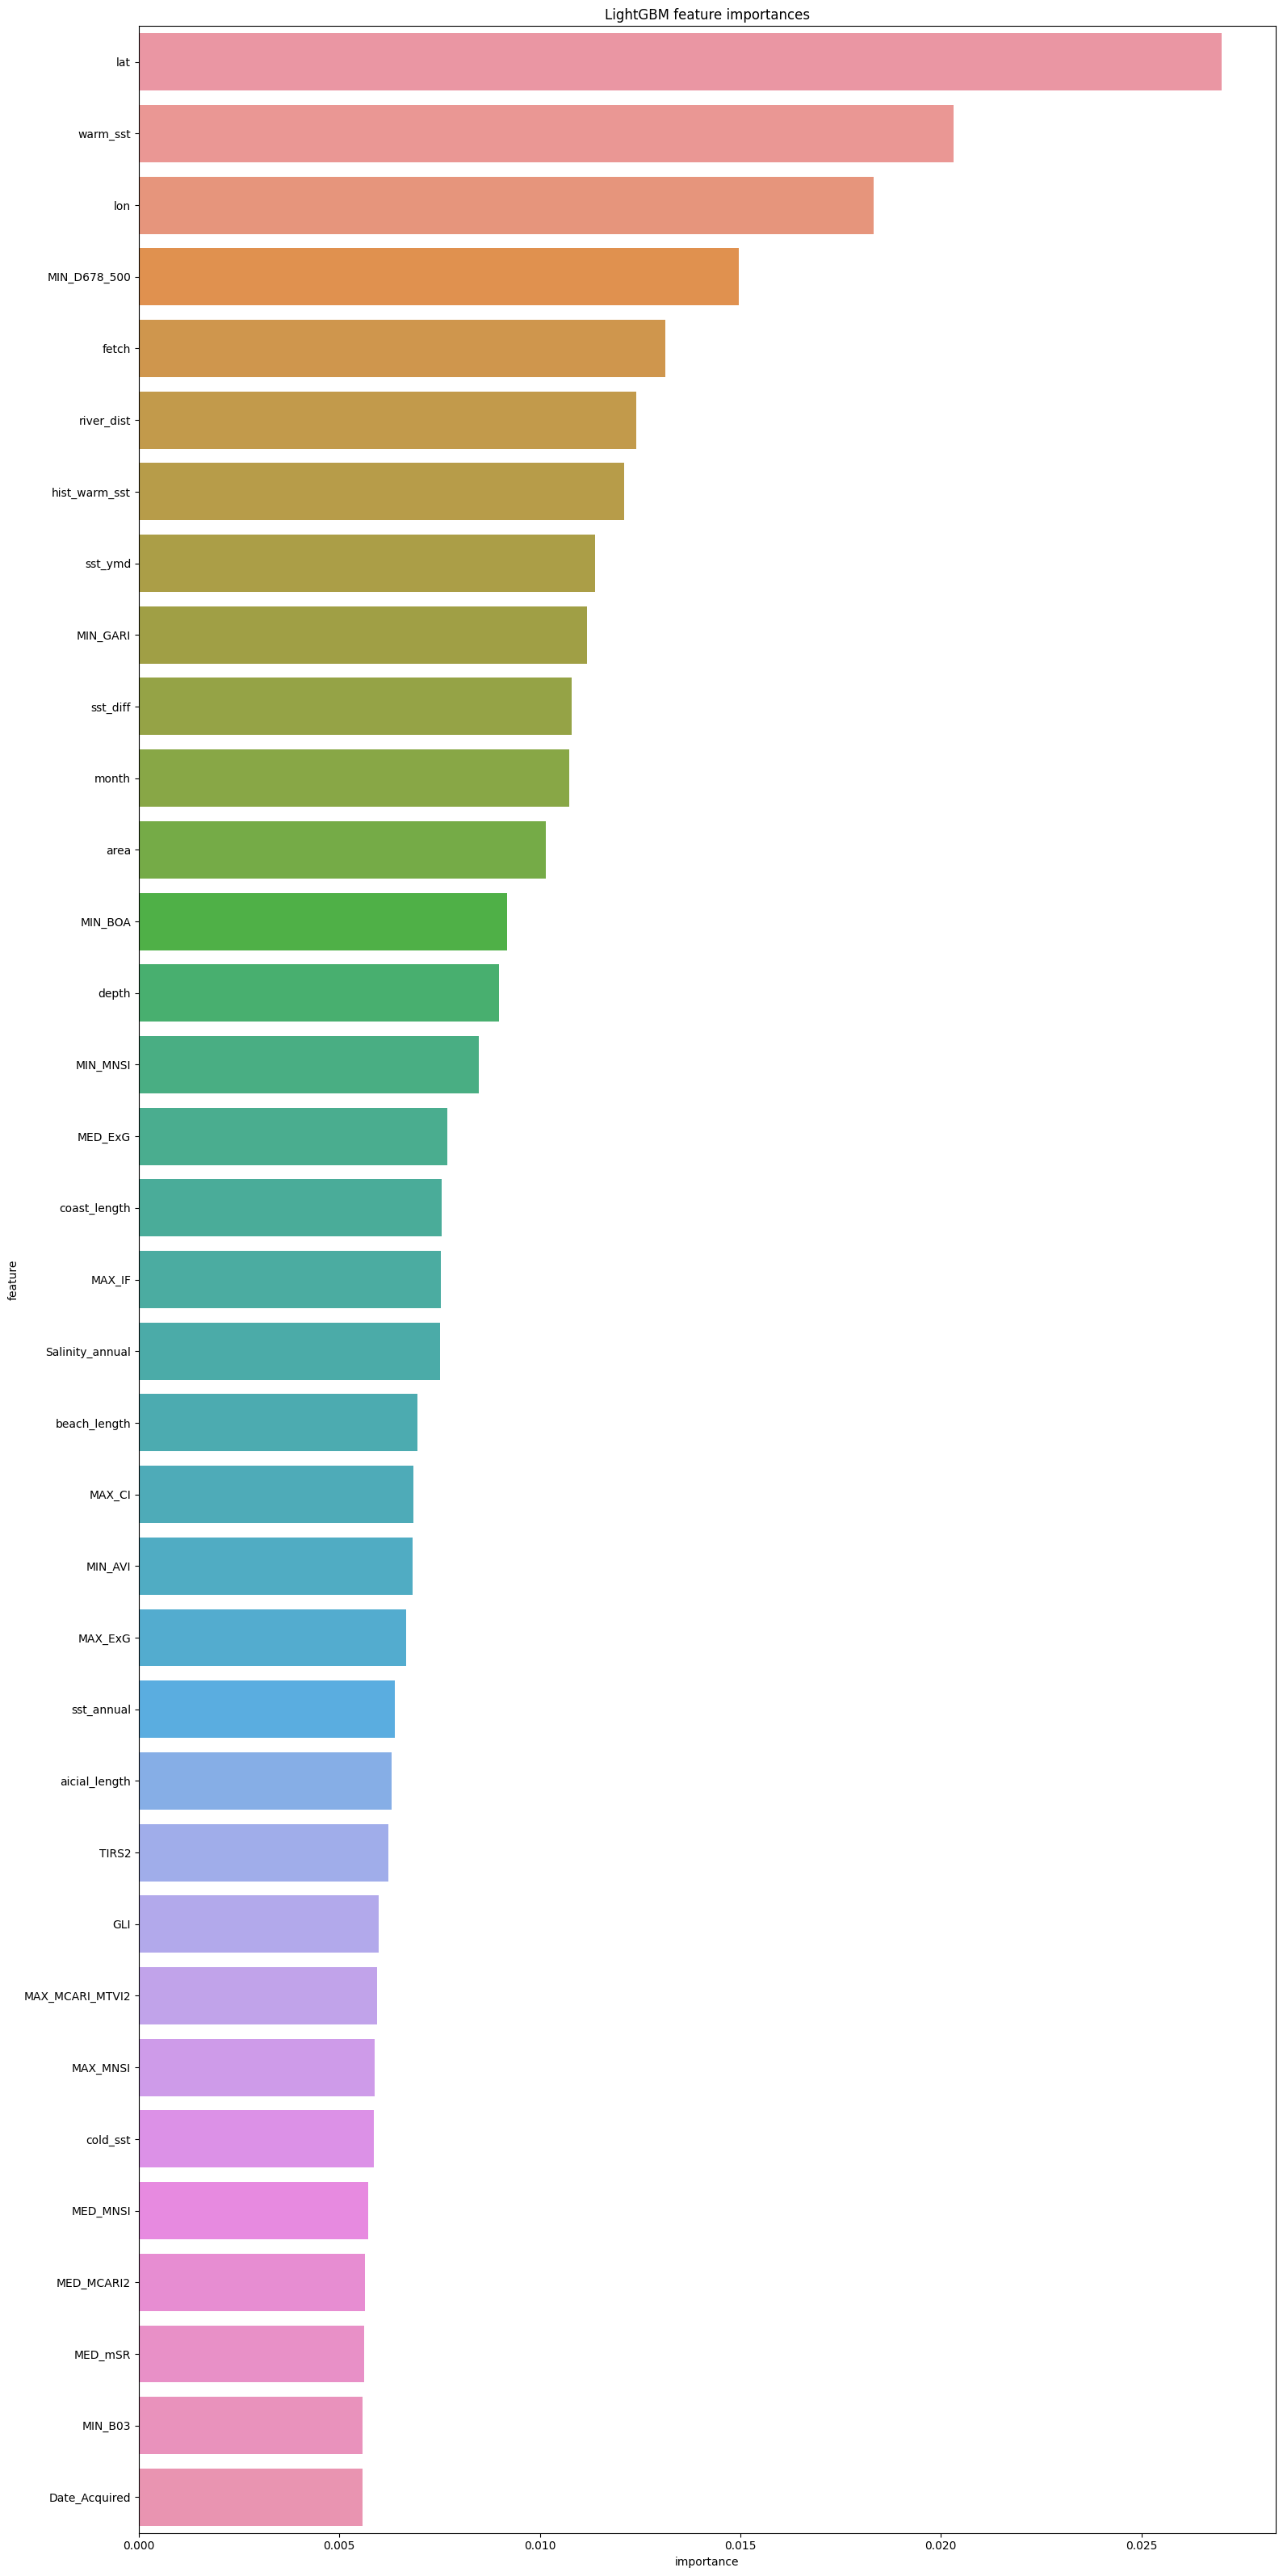

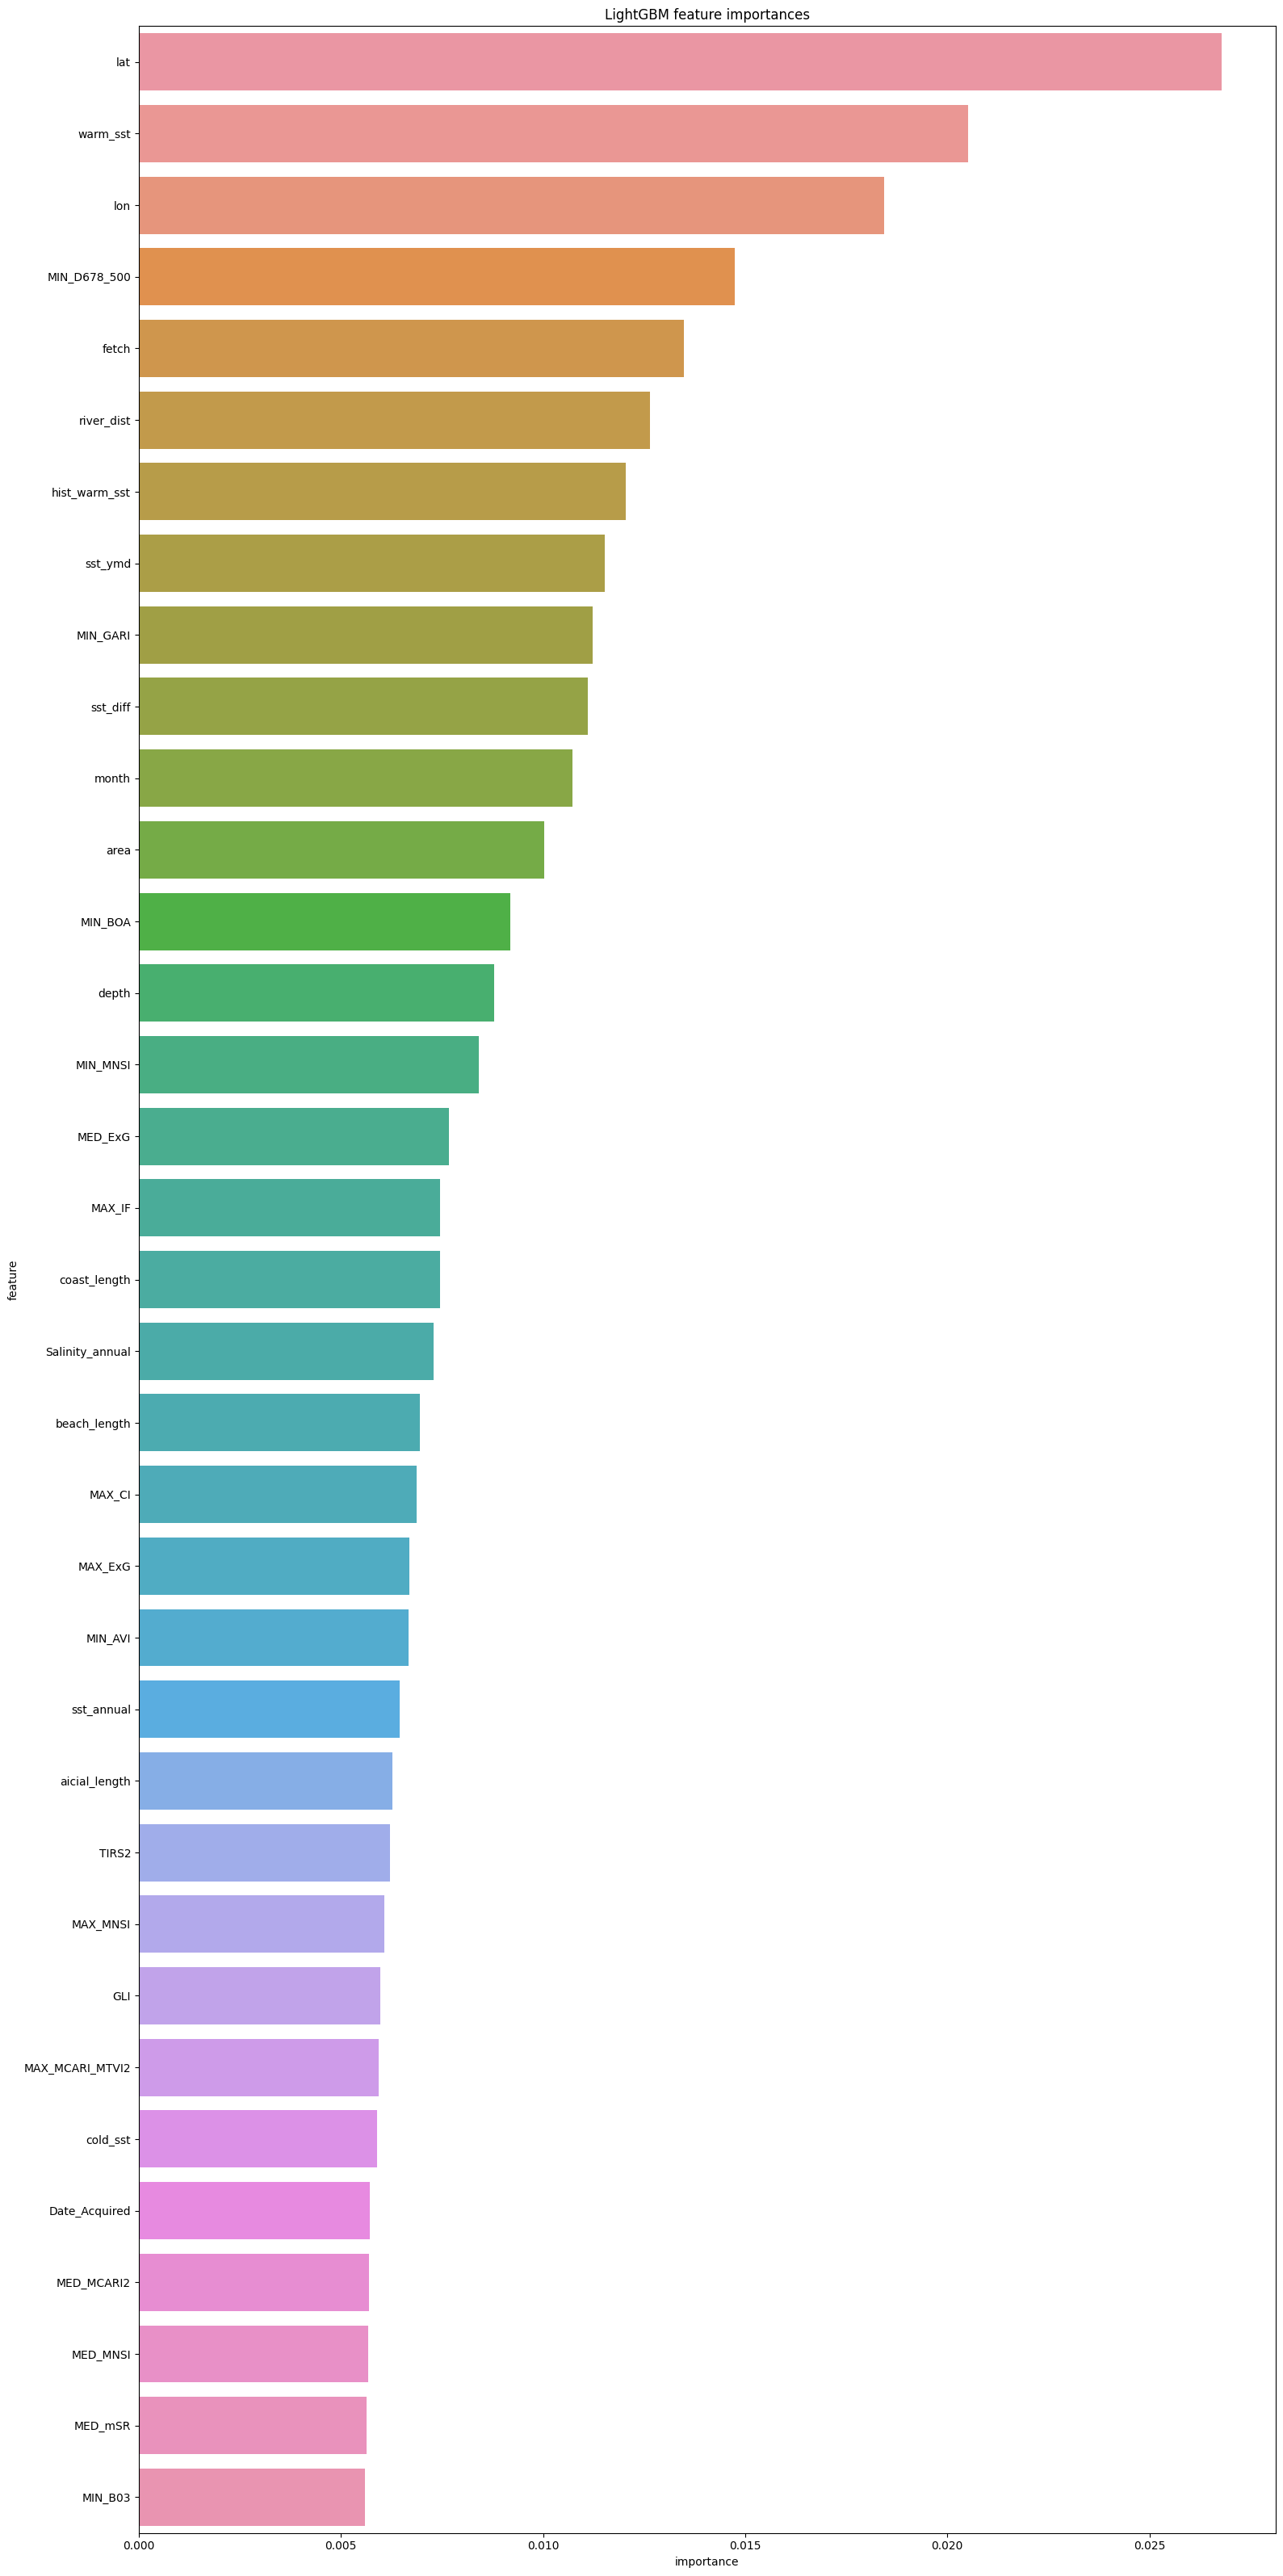

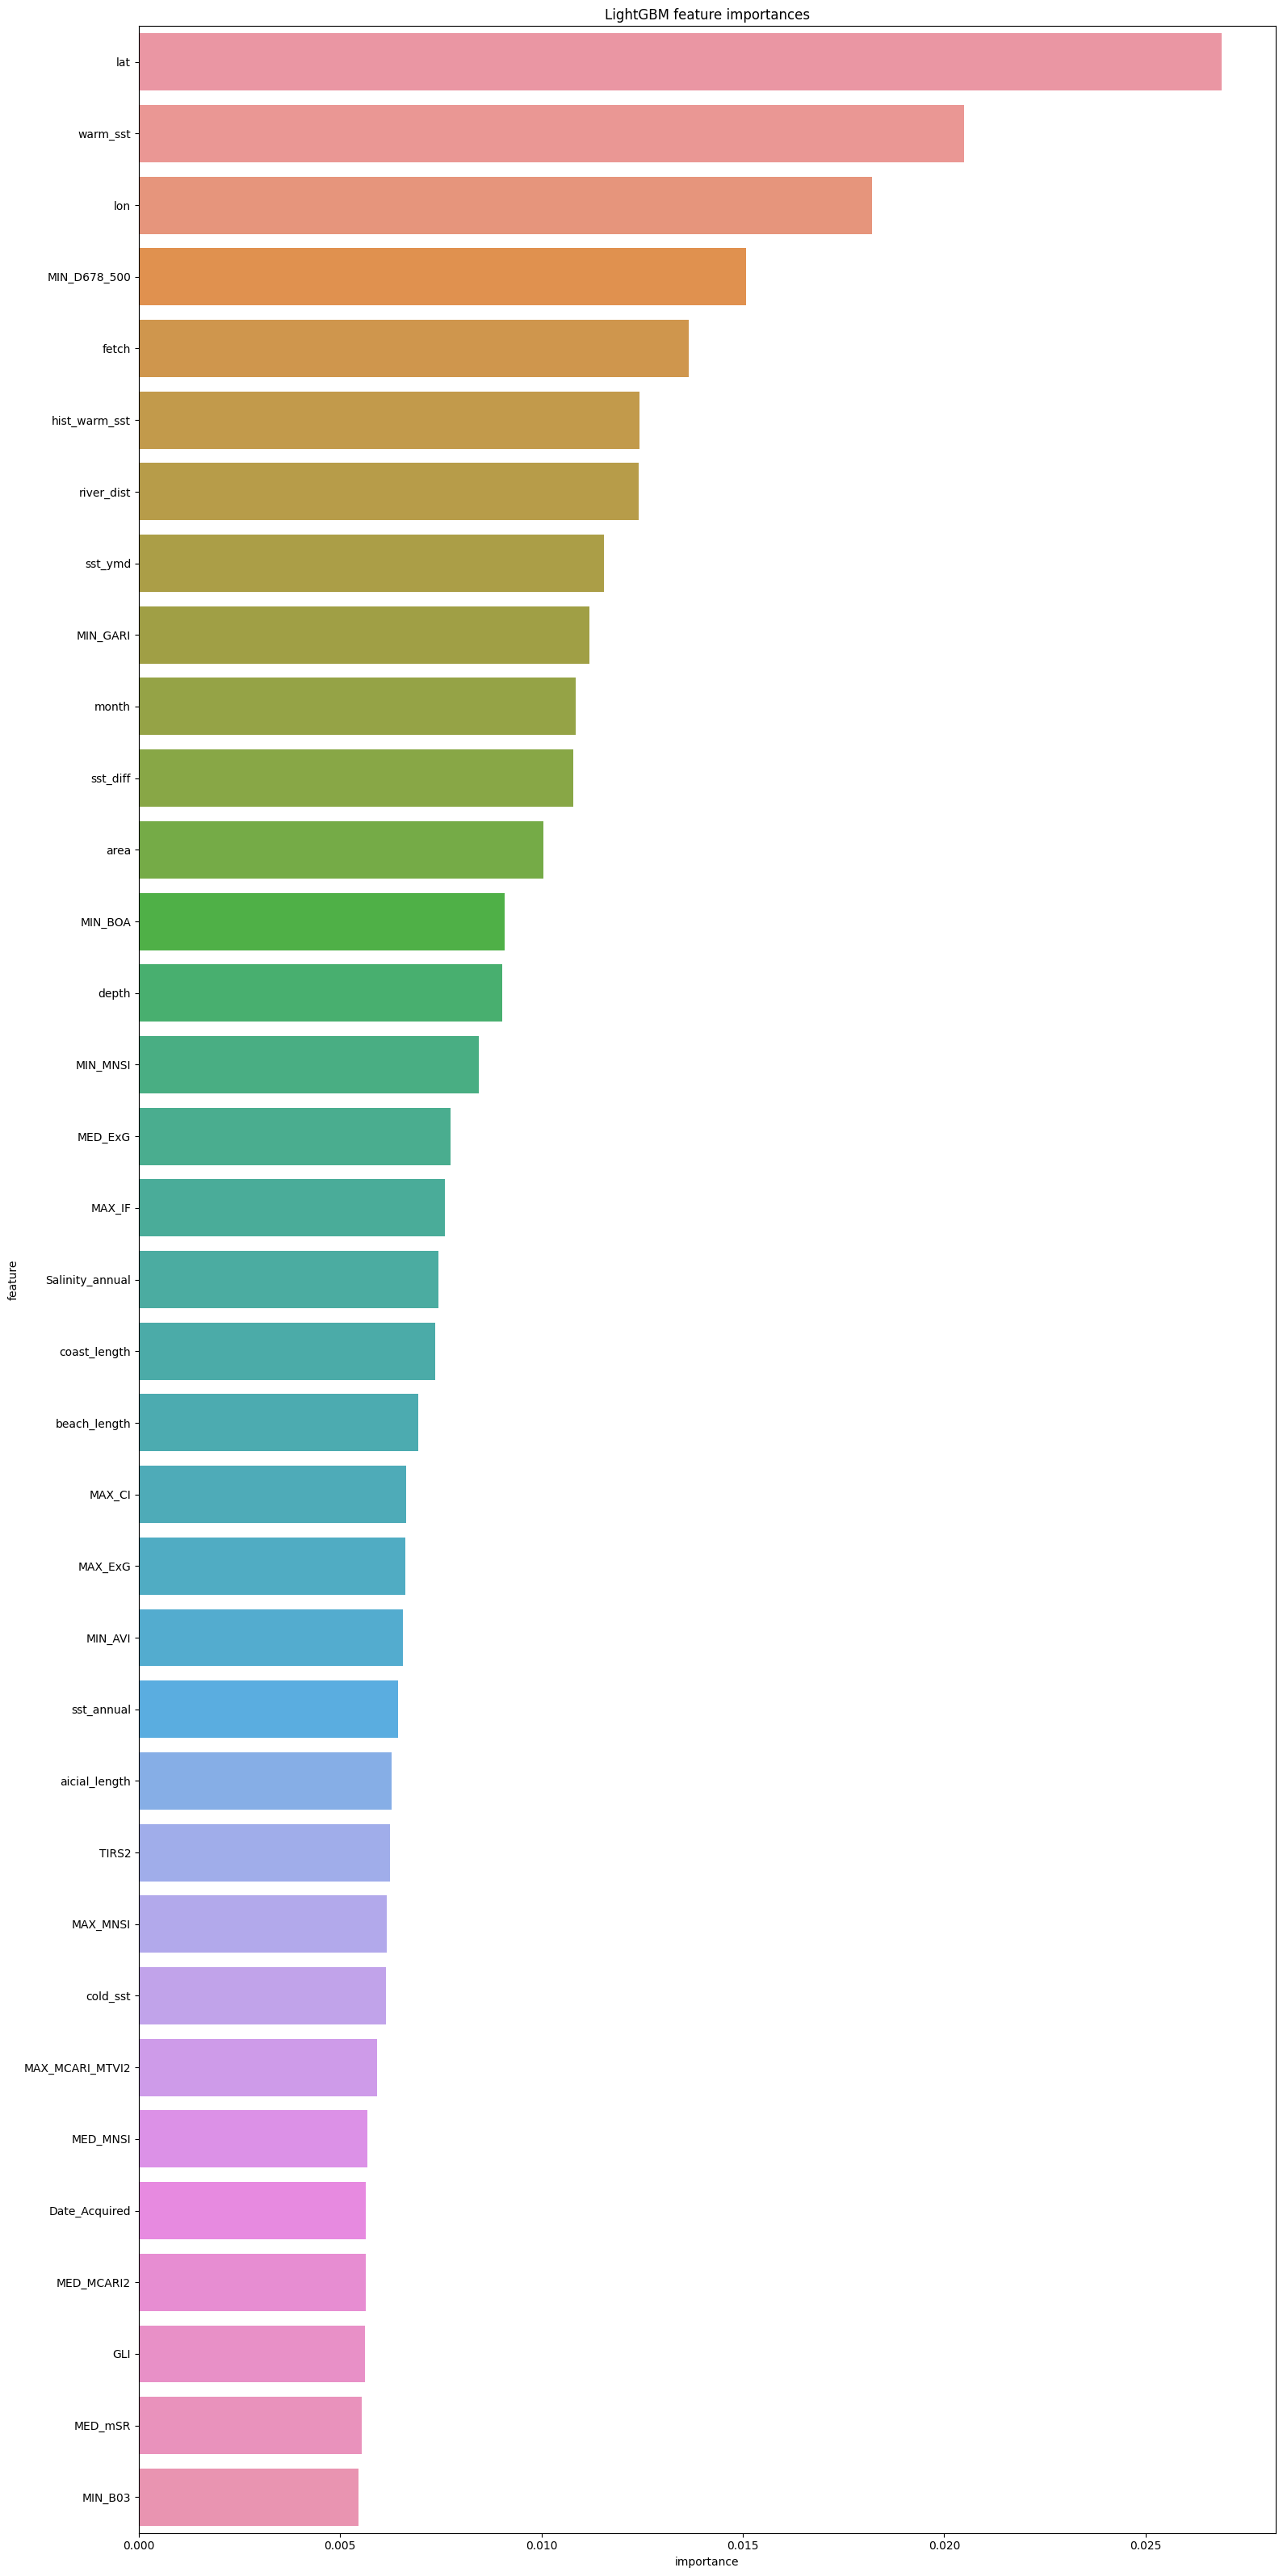

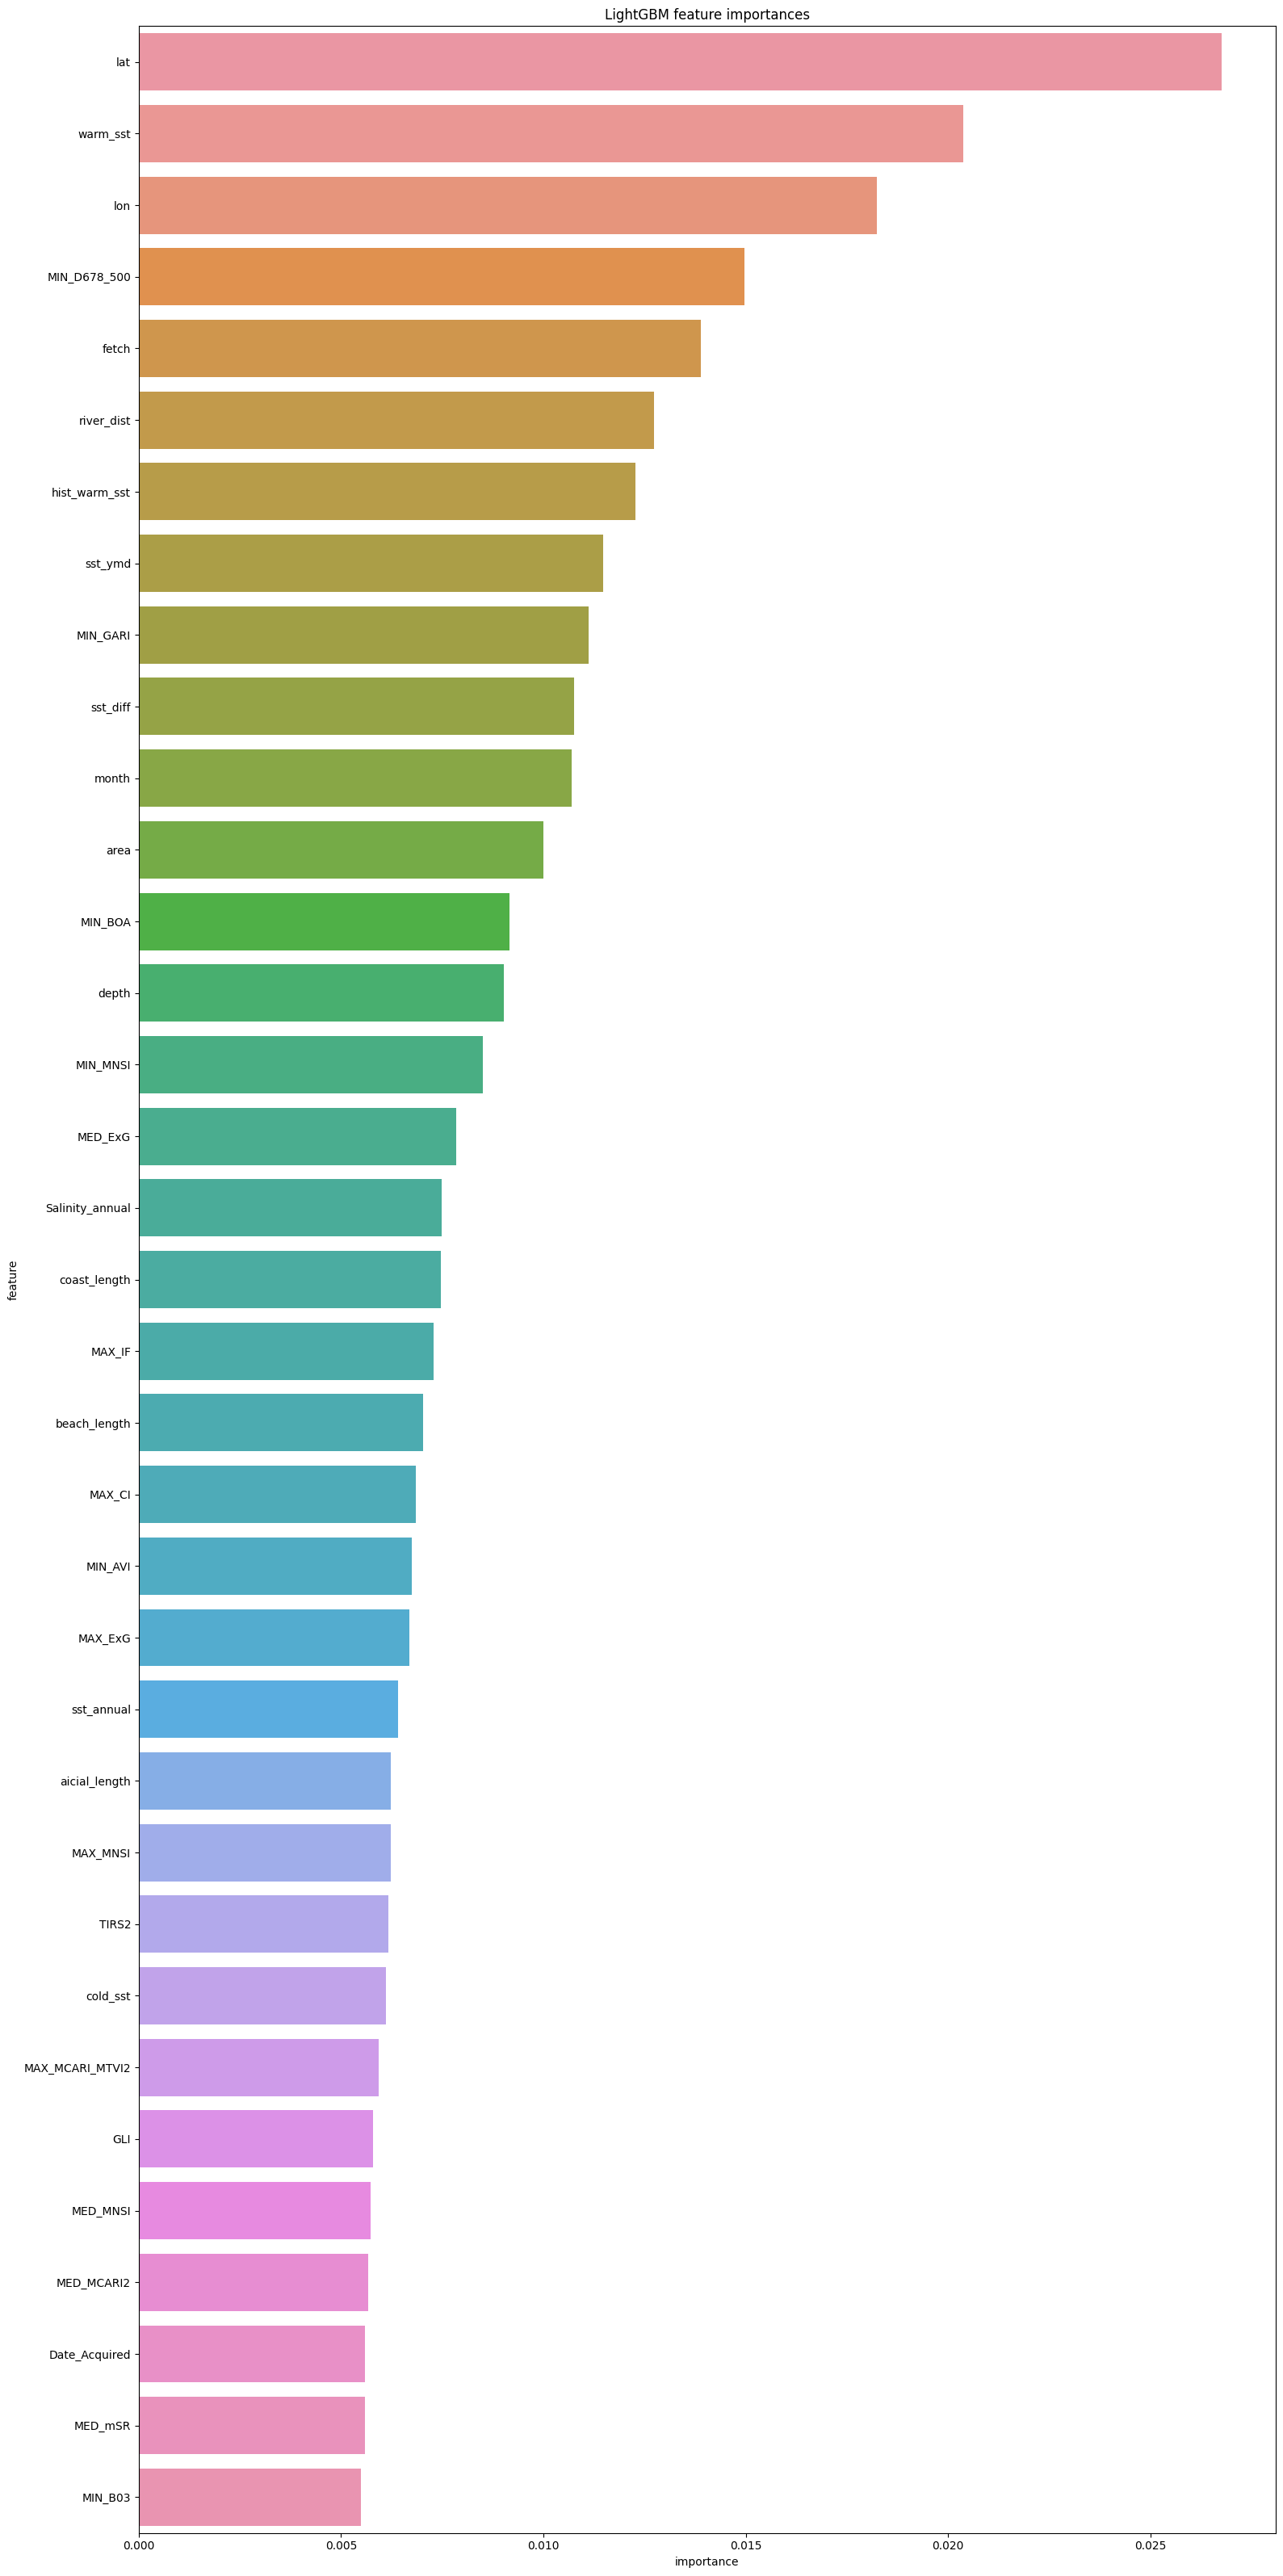

In [22]:
train['year-month'] = train.year.astype(int).astype(str) + '-' + train.month.astype(int).astype(str)
train['year-month'] = pd.to_datetime(train['year-month'], format='%Y-%m')
train = train.sort_values("year-month").reset_index(drop=True)
train = get_fold(train)
oof_preds = []
preds = np.zeros((len(test), 4))
seeds = [42, 18, 0, 2023]
for i in range(4):
  print("#"*15,f" SEED : {CFG.seed} ","#"*15)
  params["seed"] = seeds[i]
  oof_df, test_pred = get_pred(train, test, params)
  pred = np.mean(test_pred, axis=1)
  preds[:, i] = pred
  oof_preds.append(oof_df["pred"].values)
  print()

In [23]:
cover_max = train.cover.max()
_oof = oof_df.copy()
_oof["pred"] = np.mean(oof_preds, axis=0)
_oof["pred"] = _oof["pred"].apply(lambda x: x if x>0 else 0)
_oof["pred"] = _oof["pred"].apply(lambda x: x if x<1 else cover_max)
get_score(_oof["cover"], _oof["pred"])

RMSE 0.16302745121122117


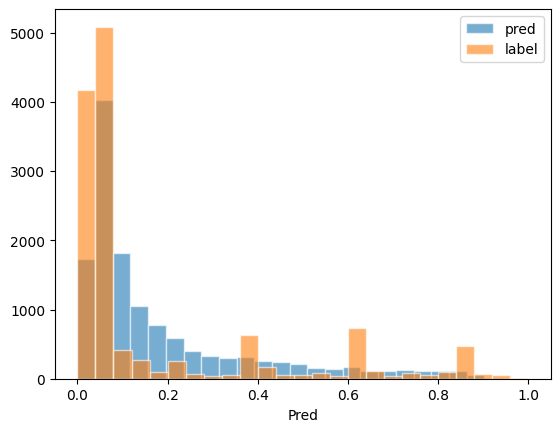

In [24]:
plt.hist(_oof.pred, label='pred', bins=25, edgecolor='white', alpha=.6)
plt.hist(_oof.cover, label="label", bins=25, edgecolor='white', alpha=.6)
plt.xlabel("Pred")
plt.legend()
plt.show()

In [25]:
pred_df = test.copy()
pred_df["pred"] = np.mean(preds, axis=1)

pred_df = pred_df.sort_index()
pred_df

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,knn_Ferric_Oxides,knn_SLAVI,knn_AVI,knn_SIPI2,knn_Green,knn_SWIR2,knn_Chlred_edge,knn_BWDRVI,knn_Date_Acquired,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.088156,868.810277,-17.434855,5.472865,46.825167,0.341719,1.554244,-0.918048,1.999759e+07,0.006204
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.100038,136.242456,-13.141754,7.369578,35.449848,0.203959,1.749661,-0.969327,2.009092e+07,0.144974
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.086700,905.070874,-15.260981,5.576378,46.699800,0.365417,1.390758,-0.914342,1.999759e+07,0.248076
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.067491
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.426384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.097438
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.076366
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,0.088156,868.810277,-17.434855,5.472865,46.825167,0.341719,1.554244,-0.918048,1.999759e+07,0.390738
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.167158


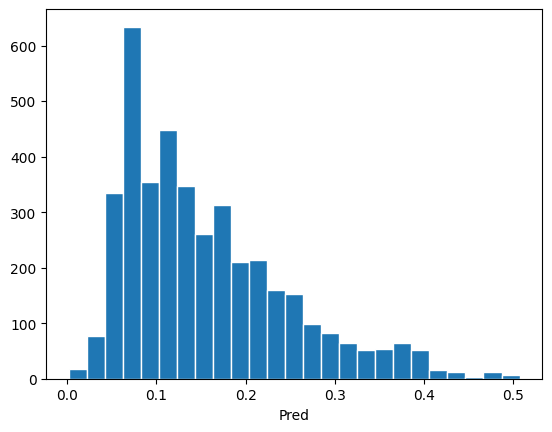

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,knn_Ferric_Oxides,knn_SLAVI,knn_AVI,knn_SIPI2,knn_Green,knn_SWIR2,knn_Chlred_edge,knn_BWDRVI,knn_Date_Acquired,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.088156,868.810277,-17.434855,5.472865,46.825167,0.341719,1.554244,-0.918048,1.999759e+07,0.006204
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.100038,136.242456,-13.141754,7.369578,35.449848,0.203959,1.749661,-0.969327,2.009092e+07,0.144974
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.086700,905.070874,-15.260981,5.576378,46.699800,0.365417,1.390758,-0.914342,1.999759e+07,0.248076
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.067491
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.426384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.097438
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.076366
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,0.088156,868.810277,-17.434855,5.472865,46.825167,0.341719,1.554244,-0.918048,1.999759e+07,0.390738
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.167158


In [26]:
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x>0 else 0)
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x<1 else cover_max)
pred_df[["pred"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_SEEDAVERAGE_ver{CFG.ver}.csv'), header=False)

plt.hist(pred_df.pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(pred_df)